In [132]:
# Download Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

print("Path to dataset files:", path)

# new dataset name
org_dir = 'videos_org'
org_path = path + '/' + org_dir

print(org_path)

# !source activate video
# !python utils/reorg.py {org_dir} 0

Path to dataset files: /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5
/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos_org


In [124]:
!git clone https://github.com/whwu95/MVFNet.git

Cloning into 'MVFNet'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 310 (delta 113), reused 273 (delta 87), pack-reused 0 (from 0)
Receiving objects: 100% (310/310), 20.42 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [133]:

directory = 'wlasl_10'
resized_dir = path + '/resized_' + directory
frame_dir = path + '/frames_' + directory
print(resized_dir)
print(frame_dir)

/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10
/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10


In [135]:
!python MVFNet/data_process/video_resize.py {org_path} {resized_dir} --level 2 -se 256
!python MVFNet/data_process/video2image.py {resized_dir} {frame_dir} --level 2 --lib opencv --prefix image_%04d.jpg
!rm -r {resized_dir}
!rm -r ./MVFNet

100%|█████████████████████████████████████| 11980/11980 [02:33<00:00, 78.12it/s]
rm: remove write-protected regular file './MVFNet/.git/objects/pack/pack-8a73c7a021b9c4c83a2451ad2d45e4964b67632d.idx'? ^C


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import random


# !export XLA_FLAGS=--xla_gpu_cuda_data_dir="/home/tkg5kq/.conda/envs/video/lib/python3.11/site-packages/triton/third_party/cuda/bin"

2024-12-12 08:32:06.860094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 08:32:06.862772: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 08:32:06.894868: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 08:32:06.896159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 08:32:14.597351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results  = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
def draw_styled_landmarks(image, results, mp_drawing, mp_holistic):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
random.seed(100)
num_classes = 10
frames_path = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos_org/'
image_height = 64
image_width = 80
plt.figure(figsize=(20,20))

classes = os.listdir(frames_path)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

<Figure size 2000x2000 with 0 Axes>

I0000 00:00:1733930955.024781  266535 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733930955.106268  298798 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA A40/PCIe/SSE2
W0000 00:00:1733930955.154406  298705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.171880  298776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.173554  298795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.174540  298791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.17

image_0045.jpg
image_0045.jpg


W0000 00:00:1733930955.333770  298802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.351395  298879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.353046  298864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.353170  298839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.354042  298896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.357776  298873 inference_feedback_manager.cc:114] Feedback manager 

image_0045.jpg
image_0031.jpg


W0000 00:00:1733930955.540578  298973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.541104  298976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733930955.594147  266535 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733930955.639003  299092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA A40/PCIe/SSE2
W0000 00:00:1733930955.683422  299001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.698232  299070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930955.69

image_0045.jpg
image_0045.jpg


W0000 00:00:1733930956.042681  299242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.060831  299269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.062774  299246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.063757  299245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.063979  299244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.068286  299276 inference_feedback_manager.cc:114] Feedback manager 

image_0045.jpg
image_0045.jpg


W0000 00:00:1733930956.247802  299374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.251680  299357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.252497  299367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733930956.305713  266535 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733930956.349427  299486 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA A40/PCIe/SSE2
W0000 00:00:1733930956.396253  299392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.41

image_0045.jpg
image_0045.jpg


W0000 00:00:1733930956.754097  299586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.769796  299662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.787053  299597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.787053  299671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.787314  299672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733930956.790017  299615 inference_feedback_manager.cc:114] Feedback manager 

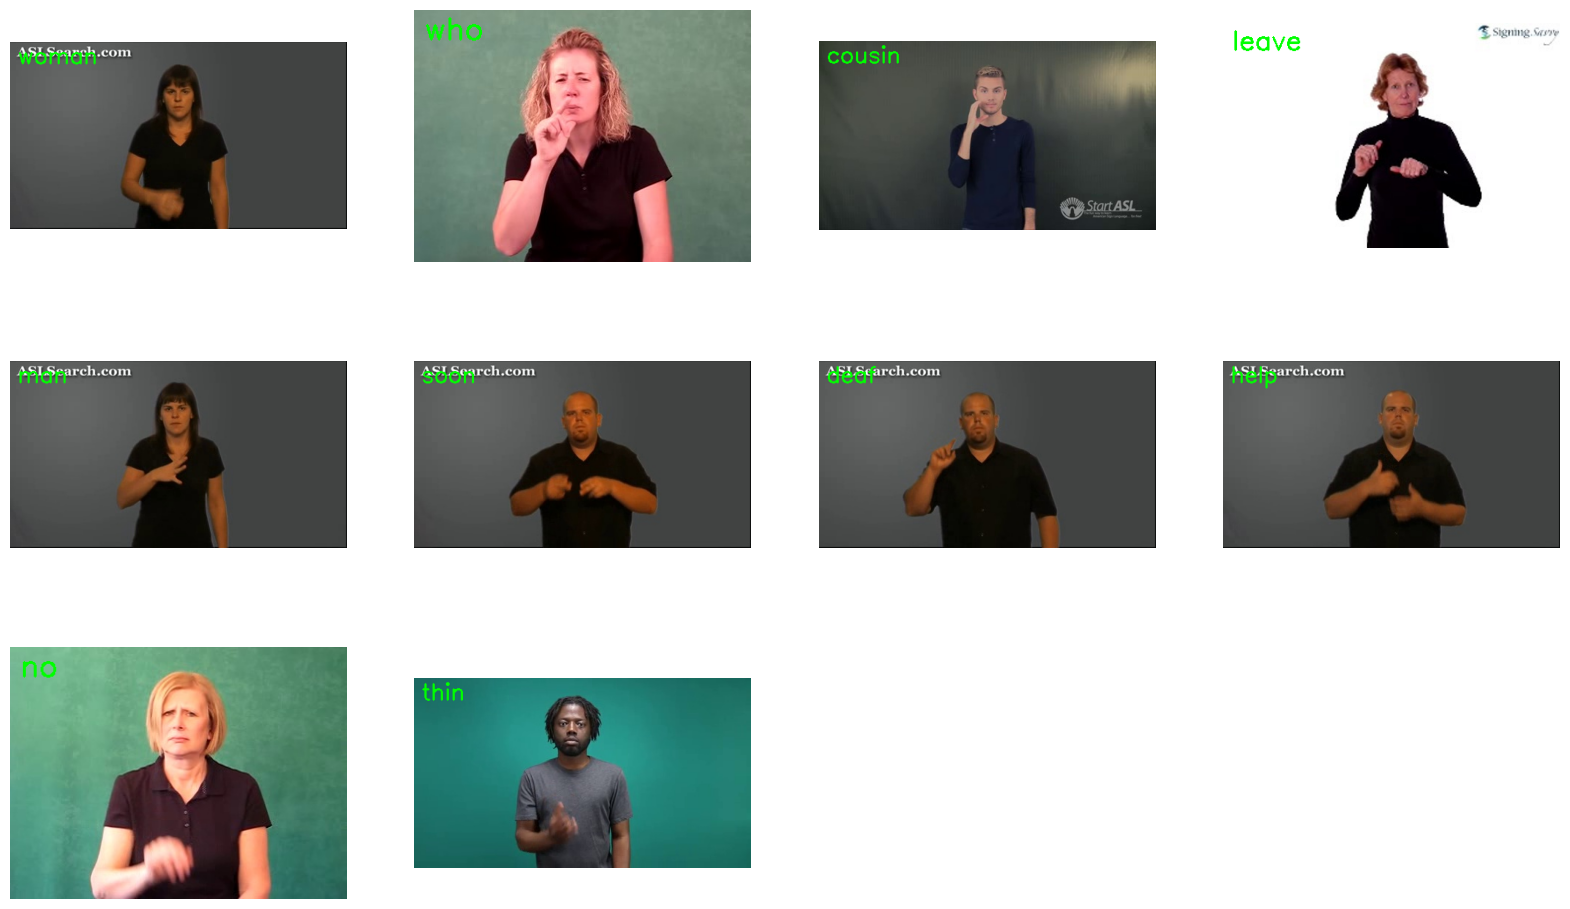

In [47]:
# def load_video_dataset(path, num_classes=20):


random_range = random.sample(range(len(classes)), num_classes)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = classes[random_index]

    video_files_names_list = os.listdir(f'{frames_path}/{selected_class_name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_frame_list = os.listdir(f'{frames_path}/{selected_class_name}/{selected_video_file_name}')

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        idx = 0
        print(video_frame_list[0])
        bgr_frame = cv2.imread(f'{frames_path}/{selected_class_name}/{selected_video_file_name}/{video_frame_list[0]}')
        bgr_frame, results = mediapipe_detection(bgr_frame, holistic) #hands.process(cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB))
        # bgr_frame = cv2.resize(bgr_frame, (image_width, image_height))

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    plt.subplot(5, 4, counter); plt.imshow(rgb_frame); plt.axis('off')

plt.show()

# load_video_dataset('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos_org')



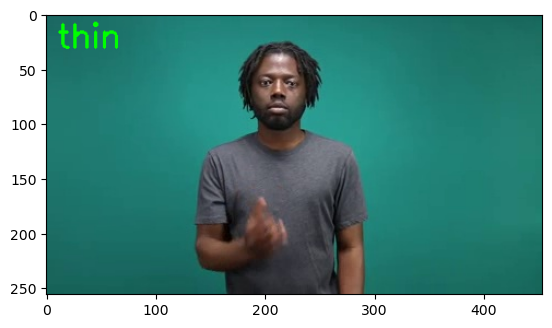

In [48]:
plt.imshow(rgb_frame)

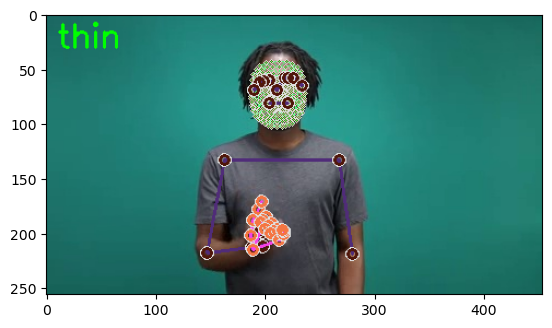

In [49]:
from copy import deepcopy

image = deepcopy(rgb_frame)

draw_styled_landmarks(image, results, mp_drawing, mp_holistic)
plt.imshow(image)

In [5]:
face_list_len = len(results.face_landmarks.landmark) if results.face_landmarks else 0
left_list_len = len(results.left_hand_landmarks.landmark) if results.left_hand_landmarks else 0
right_list_len = len(results.right_hand_landmarks.landmark) if results.right_hand_landmarks else 0
pose_list_len = len(results.pose_landmarks.landmark) if results.pose_landmarks else 0

NameError: name 'results' is not defined

In [11]:
# print(face_list_len, left_list_len, right_list_len, pose_list_len)
FACE_LIST_LEN = 468
LEFT_LIST_LEN = 21
RIGHT_LIST_LEN = 21
POSE_LIST_LEN = 33

TOTAL_LIST_LEN = FACE_LIST_LEN*3 + LEFT_LIST_LEN*3 + RIGHT_LIST_LEN*3 + POSE_LIST_LEN*4
print(TOTAL_LIST_LEN)

1662


In [113]:
for landmark in results.pose_landmarks.landmark:
    print(landmark.x)
    print(landmark.y)
    print(landmark.z)
    print(landmark.visibility)
    break


0.501240611076355
0.2738470733165741
-0.6756582260131836
0.9999323487281799


In [9]:
def extract_landmarks(results):
    pose = np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(POSE_LIST_LEN*4)
    face = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.face_landmarks.landmark]).flatten()  if results.face_landmarks else np.zeros(FACE_LIST_LEN*3)
    left = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(LEFT_LIST_LEN*3)
    right = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(RIGHT_LIST_LEN*3)
    return np.concatenate([pose, face, left, right])

In [115]:
landmarks = extract_landmarks(results)
len(landmarks), TOTAL_LIST_LEN

(1662, 1662)

In [76]:
landmarks

array([ 0.46669739,  0.27084452, -0.90979624, ...,  0.47650486,
        0.77135903,  0.0021462 ])

# Extract Data

Create a folder path and collect the numpy array of extracted pose, face, left hand, and right hand data. 

In [12]:
path = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5'
frames_path = os.path.join(path, 'frames_wlasl_10')
poses_path = os.path.join(path, 'poses')
os.makedirs(poses_path, exist_ok=True)

for count, class_name in enumerate(classes):
    class_path = f'{frames_path}/{class_name}'

    os.makedirs(f'{poses_path}/{class_name}', exist_ok=True)

    video_name_list = os.listdir(class_path)

    for video in video_name_list:
        video_path = f'{class_path}/{video}'

        frame_list = os.listdir(video_path)
        os.makedirs(f'{poses_path}/{class_name}/{video}', exist_ok=True)

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            for frame in frame_list:
                frame_path = f'{class_path}/{video}/{frame}'
                extracted_path = f'{poses_path}/{class_name}/{video}/{frame.split(".")[0].split("_")[-1]}'
                bgr_frame, results = mediapipe_detection(cv2.imread(frame_path), holistic) #hands.process(cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB))
                landmarks = extract_landmarks(results)
                # rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
                np.save(extracted_path, landmarks)
    # if count == 9:
    #     break

I0000 00:00:1734010608.220109  879164 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734010608.298138  882623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA A40/PCIe/SSE2
W0000 00:00:1734010608.346510  882528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734010608.365346  882606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734010608.366986  882570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734010608.366986  882537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734010608.36

KeyboardInterrupt: 

# Preprocessing

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [37]:
# Create a label map

classes = ['love', 'thankyou', 'face']

label_map = {label:num for num, label in enumerate(classes)}
label_map

{'love': 0, 'thankyou': 1, 'face': 2}

## Load the data

In [39]:
path = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5'
poses_path = os.path.join(path, 'poses')
sequences, labels = [], []
pose_lens = []
sample_num = 20
samples_per_video = 10
classes = ['love', 'face', 'thankyou']
for count, class_name in enumerate(classes):
    class_path = f'{poses_path}/{class_name}'

    video_name_list = os.listdir(class_path)

    for vid_cnt, video in enumerate(video_name_list):
        if (vid_cnt) > 7:
            break
        window = []
        video_path = f'{class_path}/{video}'

        poses_list = os.listdir(video_path)

        # pose_lens.append(len(poses_list))
        # threshold = 50
        # if len(poses_list) > threshold:
        #     new_poses_list = [pose for cnt, pose in enumerate(poses_list) if cnt > np.ceil((len(poses_list)-threshold)/2)-1 and cnt < len(poses_list) - np.floor((len(poses_list)-threshold)/2)]
            
        #     # if len(new_poses_list) != threshold:
        #     #     print(len(poses_list)/2, np.ceil((len(poses_list)-30)/2), len(poses_list) - np.floor((len(poses_list)-30)/2))
        #     #     print(len(poses_list))

        #     poses_list = new_poses_list
        # elif len(poses_list) < threshold:
        #     # print(len(poses_list), np.ceil((threshold-len(poses_list))/2), np.floor((threshold-len(poses_list))/2))
        #     front_pad = [poses_list[0] for i in range(int(np.ceil((threshold-len(poses_list))/2)))]
        #     back_pad = [poses_list[-1] for i in range(int(np.floor((threshold-len(poses_list))/2)))]
        #     poses_list = front_pad + poses_list
        #     poses_list.extend(back_pad)
        #     if len(poses_list) != threshold:
        #         print(len(poses_list))
        #     # print(len(poses_list))
        window = np.empty((len(poses_list), TOTAL_LIST_LEN))
        for pose_cnt, pose in enumerate(poses_list):

            pose_path = f'{video_path}/{pose}'
            res = np.load(pose_path)

            window[pose_cnt] = res

        for _ in range(samples_per_video):
            # print(pose_cnt, np.array(window).shape)
            random_sequence = sorted(random.sample(range(pose_cnt+1), 20))
            # print(random_sequence)
            new_window = window[random_sequence, :]
            sequences.append(new_window)
            labels.append(label_map[class_name])
    # if count == 5:
    #     break

In [40]:
np.array(sequences).shape

(220, 20, 1662)

In [41]:
np.array(labels).shape

(220,)

In [42]:
np.array(labels)
y = to_categorical(labels).astype(int)
print(y)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(np.array(sequences), y, test_size=0.2)

In [44]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((176, 20, 1662), (176, 3), (44, 20, 1662), (44, 3))

The data is now created and set up. It is time to train the neural network

## LSTM NN

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense # fully connected layer
from tensorflow.keras.callbacks import TensorBoard

In [46]:
import os
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [47]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos])
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:CPU:0']


2024-12-12 09:02:26.192557: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [52]:
import tensorflow as tf


# Set the visible GPUs
# gpus = get_available_gpus()
# print(gpus)
# if gpus:
#     # Create a MirroredStrategy
#     strategy = tf.distribute.MirroredStrategy()
#     print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    # Define your model and compile it within the strategy scope
    # with strategy.scope():
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(np.array(classes).shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print(X_train.shape, y_train.shape)
model.fit(X_train, y_train, epochs=40) #, callbacks=[tb_callback])


Epoch 1/40
6/6 [==============================] - 2s 17ms/step - loss: 1.7527 - categorical_accuracy: 0.3239
Epoch 2/40
6/6 [==============================] - 0s 15ms/step - loss: 1.1184 - categorical_accuracy: 0.3352
Epoch 3/40
6/6 [==============================] - 0s 15ms/step - loss: 1.3810 - categorical_accuracy: 0.4432
Epoch 4/40
6/6 [==============================] - 0s 15ms/step - loss: 1.0579 - categorical_accuracy: 0.3920
Epoch 5/40
6/6 [==============================] - 0s 15ms/step - loss: 0.8071 - categorical_accuracy: 0.7727
Epoch 6/40
6/6 [==============================] - 0s 15ms/step - loss: 0.7185 - categorical_accuracy: 0.6875
Epoch 7/40
6/6 [==============================] - 0s 15ms/step - loss: 0.6069 - categorical_accuracy: 0.6534
Epoch 8/40
6/6 [==============================] - 0s 15ms/step - loss: 0.6144 - categorical_accuracy: 0.7216
Epoch 9/40
6/6 [==============================] - 0s 16ms/step - loss: 0.7170 - categorical_accuracy: 0.7045
Epoch 10/40
6/6 [==

In [53]:
res = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [54]:
print(f'{(np.sum([classes[np.argmax(res[idx])] == classes[np.argmax(y_test[idx])] for idx in range(len(res))])/len(res))*100:02f}%')

93.181818%
